Dataset: procese.csv
Cases: 8
Events: 75
Activities: 15

1. INDUCTIVE MINER


replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Fitness: 1.0000
Precision: 0.7845

2. ALPHA MINER


replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Fitness: 0.9006
Precision: 0.9759

3. HEURISTIC MINER


replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Fitness: 1.0000
Precision: 0.9785

COMPARISON
Algorithm            Fitness    Precision 
----------------------------------------
Inductive Miner      1.0000     0.7845    
Alpha Miner          0.9006     0.9759    
Heuristic Miner      1.0000     0.9785    

Best: Heuristic Miner
Fitness: 1.0000
Precision: 0.9785
 Inductive Miner...


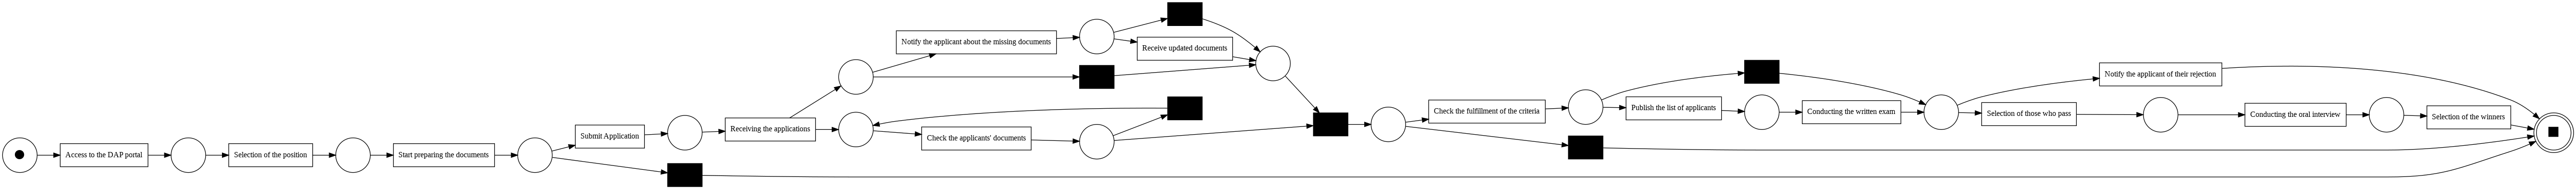

 Alpha Miner...


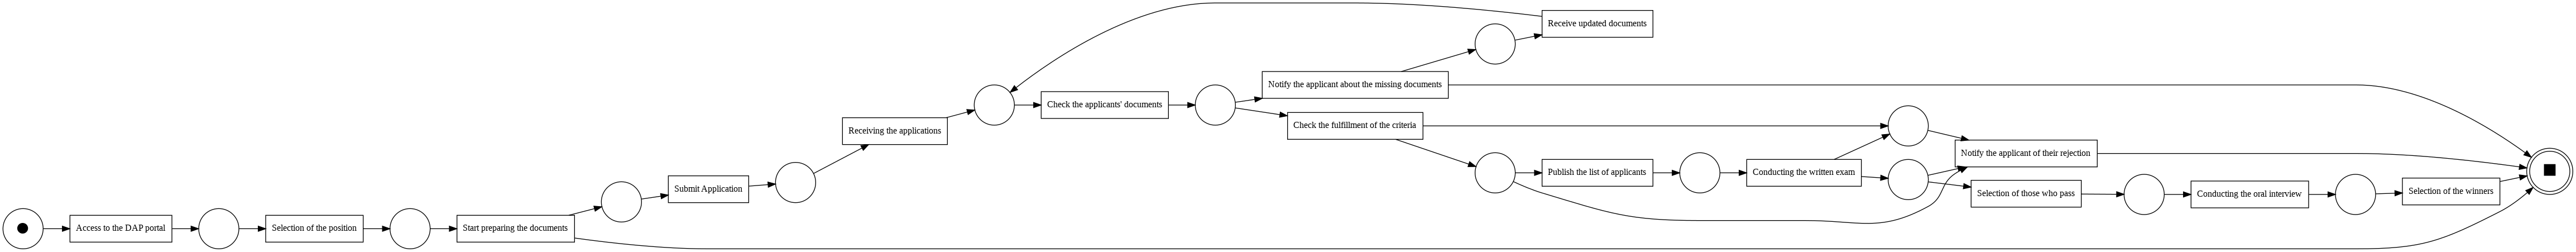

 Heuristic Miner...


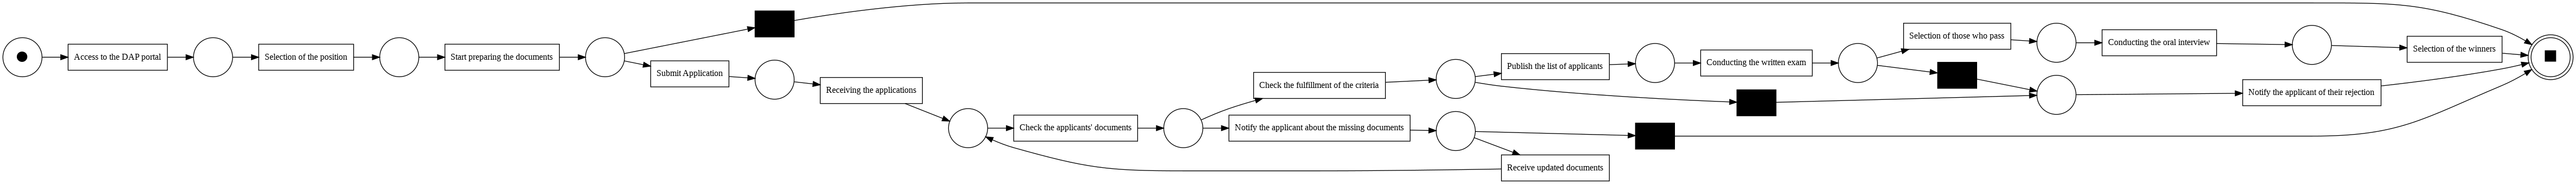

In [43]:
!pip install pm4py pandas --quiet

import pandas as pd
import pm4py

csv_filename = "procese.csv"
df = pd.read_csv(csv_filename)

case_id_column = 'CaseID'
activity_column = 'Activity'
timestamp_column = 'Timestamp'

df_prepared = df.rename(columns={
    case_id_column: 'case:concept:name',
    activity_column: 'concept:name',
    timestamp_column: 'time:timestamp'
})

df_prepared['case:concept:name'] = df_prepared['case:concept:name'].astype(str)
df_prepared['concept:name'] = df_prepared['concept:name'].astype(str)
df_prepared['time:timestamp'] = pd.to_datetime(df_prepared['time:timestamp'])

df_prepared = df_prepared.sort_values(['case:concept:name', 'time:timestamp'])
log = pm4py.convert_to_event_log(df_prepared)

print(f"Dataset: {csv_filename}")
print(f"Cases: {df_prepared['case:concept:name'].nunique()}")
print(f"Events: {len(df_prepared)}")
print(f"Activities: {df_prepared['concept:name'].nunique()}")

results = {}

print("\n1. INDUCTIVE MINER")
try:
    net_im, initial_marking_im, final_marking_im = pm4py.discover_petri_net_inductive(log)
    fitness_im = pm4py.fitness_token_based_replay(log, net_im, initial_marking_im, final_marking_im)
    precision_im = pm4py.precision_token_based_replay(log, net_im, initial_marking_im, final_marking_im)

    results['Inductive Miner'] = {
        'fitness': fitness_im['log_fitness'],
        'precision': precision_im,
        'net': net_im,
        'initial_marking': initial_marking_im,
        'final_marking': final_marking_im
    }

    print(f"Fitness: {fitness_im['log_fitness']:.4f}")
    print(f"Precision: {precision_im:.4f}")

except Exception as e:
    print(f"Error: {e}")

print("\n2. ALPHA MINER")
try:
    net_alpha, initial_marking_alpha, final_marking_alpha = pm4py.discover_petri_net_alpha(log)
    fitness_alpha = pm4py.fitness_token_based_replay(log, net_alpha, initial_marking_alpha, final_marking_alpha)
    precision_alpha = pm4py.precision_token_based_replay(log, net_alpha, initial_marking_alpha, final_marking_alpha)

    results['Alpha Miner'] = {
        'fitness': fitness_alpha['log_fitness'],
        'precision': precision_alpha,
        'net': net_alpha,
        'initial_marking': initial_marking_alpha,
        'final_marking': final_marking_alpha
    }

    print(f"Fitness: {fitness_alpha['log_fitness']:.4f}")
    print(f"Precision: {precision_alpha:.4f}")

except Exception as e:
    print(f"Error: {e}")

print("\n3. HEURISTIC MINER")
try:
    net_heu, initial_marking_heu, final_marking_heu = pm4py.discover_petri_net_heuristics(log)
    fitness_heu = pm4py.fitness_token_based_replay(log, net_heu, initial_marking_heu, final_marking_heu)
    precision_heu = pm4py.precision_token_based_replay(log, net_heu, initial_marking_heu, final_marking_heu)

    results['Heuristic Miner'] = {
        'fitness': fitness_heu['log_fitness'],
        'precision': precision_heu,
        'net': net_heu,
        'initial_marking': initial_marking_heu,
        'final_marking': final_marking_heu
    }

    print(f"Fitness: {fitness_heu['log_fitness']:.4f}")
    print(f"Precision: {precision_heu:.4f}")

except Exception as e:
    print(f"Error: {e}")

print("\nCOMPARISON")
print(f"{'Algorithm':<20} {'Fitness':<10} {'Precision':<10}")
print("-" * 40)

for algorithm, metrics in results.items():
    fitness_val = metrics['fitness']
    precision_val = metrics['precision']
    print(f"{algorithm:<20} {fitness_val:<10.4f} {precision_val:<10.4f}")

if results:
    best_algorithm = max(results.items(), key=lambda x: (x[1]['fitness'] + x[1]['precision']) / 2)
    print(f"\nBest: {best_algorithm[0]}")
    print(f"Fitness: {best_algorithm[1]['fitness']:.4f}")
    print(f"Precision: {best_algorithm[1]['precision']:.4f}")

for algorithm, metrics in results.items():
    try:
        print(f" {algorithm}...")
        pm4py.view_petri_net(metrics['net'], metrics['initial_marking'], metrics['final_marking'])
        filename = f"{algorithm.replace(' ', '_').lower()}_model.png"
        pm4py.save_vis_petri_net(metrics['net'], metrics['initial_marking'], metrics['final_marking'], filename)
    except Exception as e:
        print(f"Visualization failed for {algorithm}: {e}")

